In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
import time
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

<br>
<left><b><font size=4>Section 1 – Data exploration and pre-processing<b><left>

In [2]:
def clean_session(full_session):
    return [word for word in list(filter(None, re.split(";|/|-|\||\.|=|$| ", full_session))) if word.isalpha()]

Dataset of all the SSH sessions

In [3]:
df_original = pd.read_parquet('ssh_attacks.parquet')
df=df_original.copy()
df['first_timestamp'] = pd.to_datetime(df['first_timestamp'])
df

session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                        first_timestamp               Set_Fingerprint  
0      2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]  
1      2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]  
2      2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]  
3      2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]  
4      2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]  
...                                 ...                           ...  
233030 2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]  
233031 2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]  
233032 2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]  
233033 2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]  
233034 2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]  

[233035 rows x 4 columns]

**1. When are the attacks performed? Analyze the temporal series.**

In [4]:
# Creating a new DataFrame containing only attack instances
# Excluding sessions labeled as "Harmless" with a single label
df_attacks = df.loc[~df["Set_Fingerprint"].apply(lambda x : "Harmless" in x and len(x) == 1)]
attacks_per_day = df_attacks['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_of_attacks_per_day")
attacks_per_day

Number_of_attacks_per_day
first_timestamp                           
2019-06-04                              82
2019-06-05                             124
2019-06-06                             117
2019-06-07                             121
2019-06-08                             118
...                                    ...
2020-02-25                             649
2020-02-26                             483
2020-02-27                             551
2020-02-28                             580
2020-02-29                             627

[257 rows x 1 columns]

The analysis of attack occurrences based on the temporal series of first_timestamp showcases a trend in attack frequency over time.
The dataset has been transformed to interpret the first_timestamp column as datetime objects for accurate temporal analysis. The subsequent process isolates attack instances within the dataset, excluding records tagged as "Harmless" with a single label.
The resulting analysis presents the number of attacks per day:

| Date_time | Attacks |
| --- | --- |
|June 4th, 2019 | 82 attacks |
|June 5th, 2019 | 124 attacks |
|June 6th, 2019 | 117 attacks |
|June 7th, 2019 | 121 attacks |
|June 8th, 2019 | 118 attacks |
| ... (continues with dates up to) |
| February 25th, 2020| 649 attacks |
| February 26th, 2020| 483 attacks |
| February 27th, 2020| 551 attacks |
| February 28th, 2020| 580 attacks |
| February 29th, 2020| 627 attacks |

This temporal series reveals fluctuations in attack intensity over time, with notable spikes and drops in attack occurrences. The observations suggest potential patterns or trends that could be further explored to understand the dynamics of these SSH shell attacks across different periods.

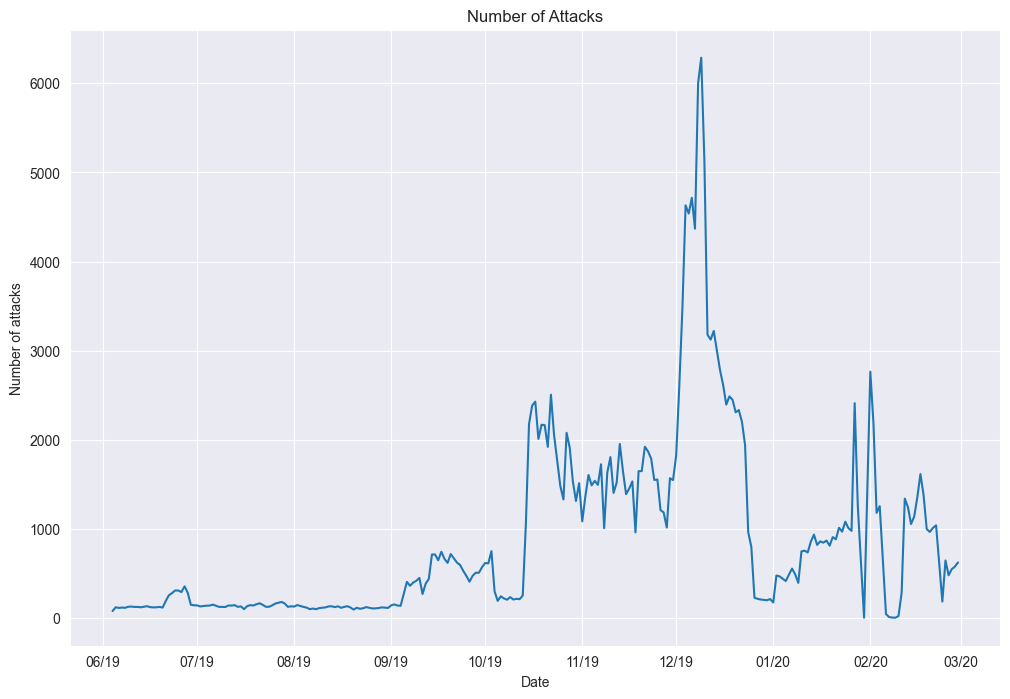

In [5]:
plt.figure(figsize=(12,8))
sns.set_style("darkgrid")

sns.lineplot(
    data = attacks_per_day,
    linestyle='-',
    color= 'blue',
    legend=False
)

plt.title('Number of Attacks')
plt.xlabel("Date")
plt.ylabel("Number of attacks")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.show()

The visualization depicting attack frequencies over time reveals distinct patterns:

Between June 2019 and September 2019, there is a conspicuous decrease in attack occurrences, indicating a phase of minimal activity. Subsequently, there is a significant surge in attack instances towards the latter part of 2019, signifying a notable rise in both the frequency and intensity of attacks during this period.

This timeline underscores a stark contrast between the relatively quiet phase observed from June to September 2019 and the pronounced escalation in attack activities, particularly notable in the latter months of the year. This shift in trend emphasizes a substantial alteration in attack behavior, marked by an extended period of low activity succeeded by a considerable surge in attack incidents towards the year's end.

Moreover, at the beginning of 2020, there is a noticeable decline in attack occurrences once more. This decline follows the heightened activity observed in late 2019, representing a shift from the increased attack rates back to a decreased frequency as the year transitions into its initial months.

In [6]:
attacks_per_year = df_attacks.groupby(df['first_timestamp'].dt.year).size().to_frame("Number_attacks").reset_index()
attacks_per_year.rename(columns={"first_timestamp": "Year"}, inplace=True)
attacks_per_year

Year  Number_attacks
0  2019          186468
1  2020           46342

The contrast in attack counts between the two years, with 2019 showing a significantly higher number of attacks compared to 2020, can be reasonably attributed to the limited temporal coverage of the dataset for the year 2020. With data available for only two months of 2020, the reduced number of observations in this period is expected and explains the lower count of attacks for that year compared to the extensive records available for 2019.

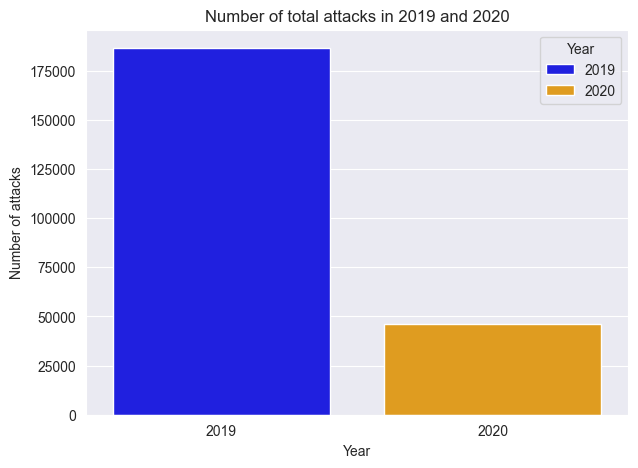

In [7]:
plt.figure(figsize=(7,5))
sns.barplot(
    data = attacks_per_year,
    x = "Year",
    y = "Number_attacks",
    hue= "Year",
    palette = ['blue','orange']
)

plt.ylabel("Number of attacks")
plt.title("Number of total attacks in 2019 and 2020")
plt.show()

In [8]:
df_attacks_2019 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2019]
df_attacks_2019_month = df_attacks_2019.groupby(df_attacks_2019["first_timestamp"].dt.month).size().to_frame("Number_attacks_2019_month").reset_index()

df_attacks_2020 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2020]
df_attacks_2020_month = df_attacks_2020.groupby(df_attacks_2020["first_timestamp"].dt.month).size().to_frame("Number_attacks_2020_month").reset_index()

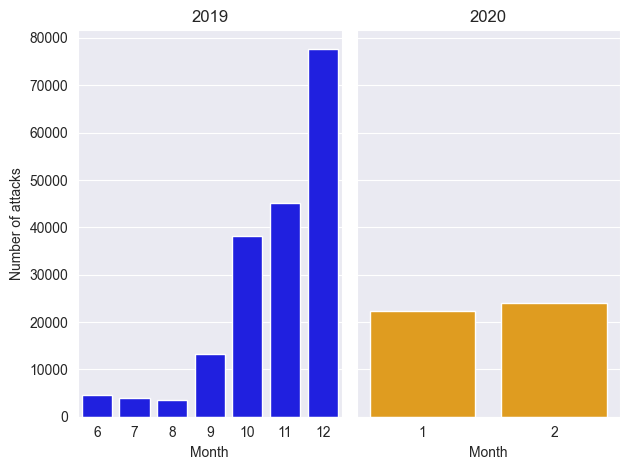

In [9]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(1,2 ,sharey=True)
plt.subplot(1,2,1)
sns.barplot(
    data = df_attacks_2019_month,
    x = "first_timestamp",
    y = "Number_attacks_2019_month",
    ax=axes[0],
    color = 'blue'  
)
plt.title("2019")
plt.xlabel("Month")
plt.ylabel("Number of attacks")

plt.subplot(1,2,2)
sns.barplot(
    data = df_attacks_2020_month,
    x = "first_timestamp",
    y = "Number_attacks_2020_month",
    ax=axes[1],
    color = 'orange'
)
plt.title("2020")
plt.xlabel("Month")
plt.ylabel("Number of attacks")

plt.tight_layout()
plt.show()

The bar charts reveal intriguing trends:

- In 2019, there is a noticeable surge in the number of attacks from months 9 to 12. A progressive increase in attack activity is observed during these months, reaching a peak towards the year's end.

- At the onset of 2020, in months 1 and 2, a relatively similar frequency of attacks is noted, approximately representing half the number of attacks compared to month 10 in 2019.

These patterns outline a significant uptick in attack activity towards the end of 2019, followed by a comparatively steady beginning in 2020 with a considerably lower number of attacks compared to the peak period of the previous year.

**1.2. Extract features from the attack sessions. How does the empirical distribution of the number of
characters in each session look like? How is the distribution of the number of word per session?**

In [10]:
# Calculate the number of characters and words in each session
number_characters = df['full_session'].apply(lambda x: len([char for char in x if char.isalpha()]))

number_words = df['full_session'].apply(lambda x: len(clean_session(x)))

data = {"number_characters": number_characters, "number_words": number_words}
df_number_characters_words = pd.DataFrame(data = data)
df_number_characters_words

number_characters  number_words
0                     167            47
1                     167            47
2                     167            47
3                     167            47
4                     167            47
...                   ...           ...
233030                312            69
233031                329            69
233032                337            69
233033                324            69
233034                325            69

[233035 rows x 2 columns]

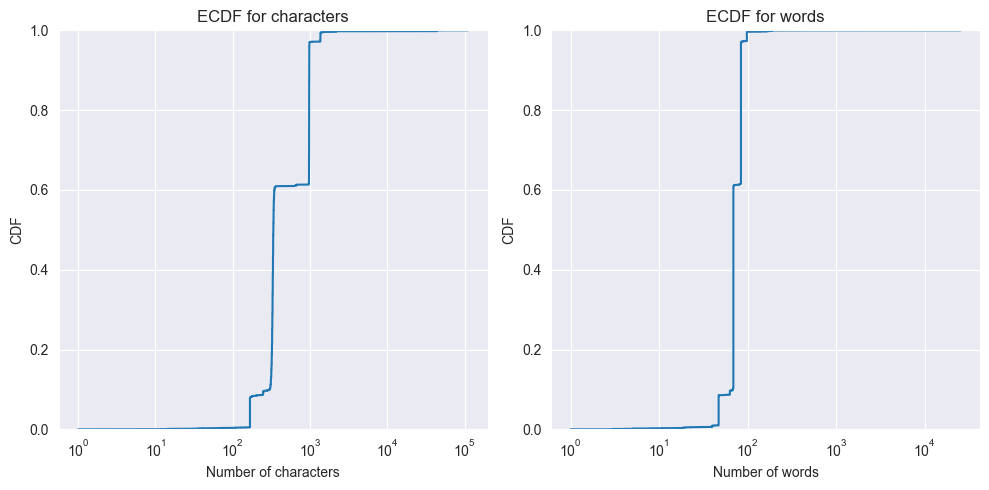

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.ecdfplot(
    data = df_number_characters_words['number_characters'],
    log_scale=True
)
plt.title("ECDF for characters")
plt.xlabel("Number of characters")
plt.ylabel("CDF")

plt.subplot(1,2,2)
sns.ecdfplot(
    data = df_number_characters_words['number_words'],
    log_scale=True
)
plt.title("ECDF for words")
plt.xlabel("Number of words")
plt.ylabel("CDF")

plt.tight_layout()
plt.show()

From the plot, it's possible to see that the distribution of words per session and the distribution of characters per session predominantly concentrate below 2000 words and below 20,000 characters, respectively.

To have a clearer idea of the distribution, we decided to limit the x-axis for both plots so that we can closely examine these two distributions

From the histograms, it is observed that the distribution of character counts per session centers is concentrated around approximately 350 characters.
Moreover, regarding the number of words per session, the distribution frequently peaks around 40 to 48 words. This indicates that sessions often contain this range of word counts, emphasizing a typical occurrence of sessions with this word count range. These insights provide a clear understanding of the common lengths observed within the attack sessions, both in terms of characters and words.

**1.3. What are the most common words in the sessions?**

In [13]:
# Joining all text from 'full_session' into a single string
full_session = ' '.join(df['full_session'])
session_cleaned = clean_session(full_session)

In [14]:
df_most_common_words = pd.Series(session_cleaned).value_counts().head(10)
most_common_word = df_most_common_words.idxmax()
frequency = df_most_common_words.max()
word_freq=df_most_common_words.to_dict()
most_common_word

'tmp'

The most common word is : 'tmp'

In [15]:
# dictionary that holds the frequencies of the top 10 most common words
word_freq

{'tmp': 1434278,
 'grep': 1278484,
 'var': 1207437,
 'cat': 1082651,
 'echo': 975322,
 'proc': 656661,
 'l': 640290,
 'uname': 639136,
 'name': 638971,
 'cpuinfo': 638867}

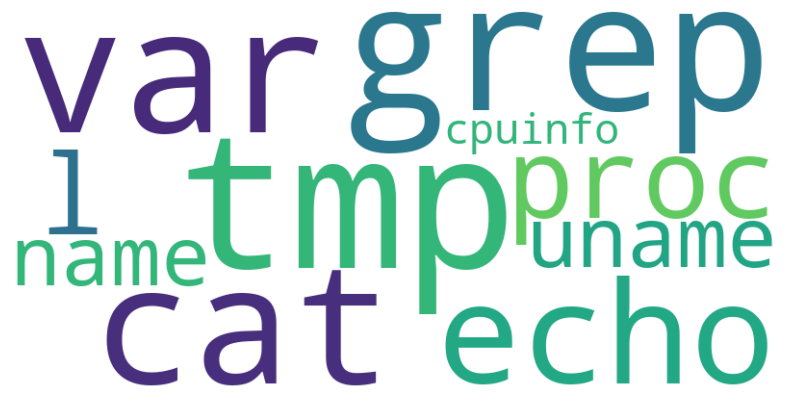

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 This representation emphasizes words based on their frequency in the sessions. Words that appear more frequently will be displayed larger and more prominently within the WordCloud. The interpolation='bilinear' argument enhances the image quality for better clarity. The plt.axis('off') command removes the axis for a cleaner visual appearance.

**1.4. How are the intents distributed? How many intents per session do you observe? What are the most common intents? How are the intents distributed in time?**

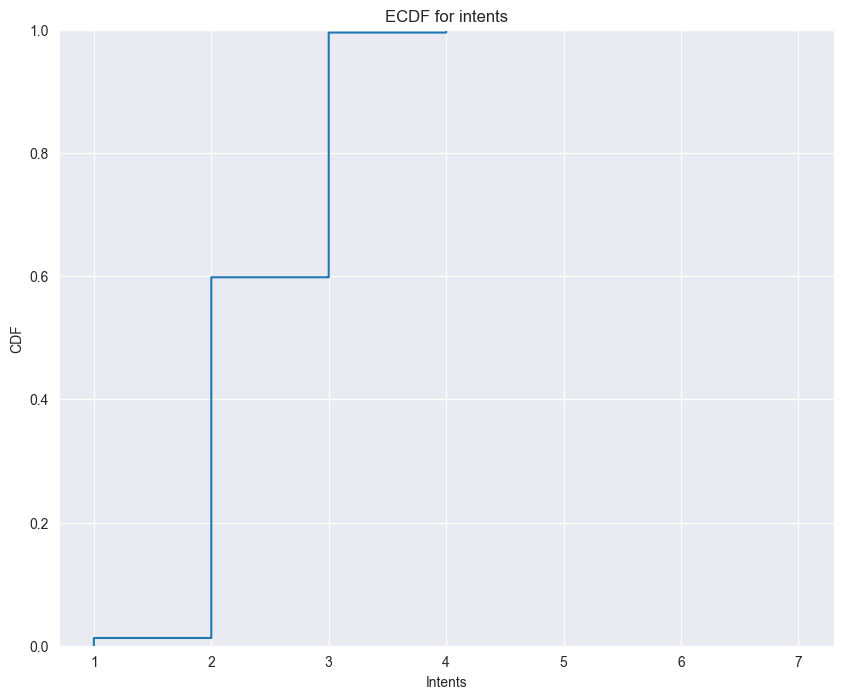

In [17]:
intents_df = df[["session_id", "first_timestamp", "Set_Fingerprint"]]

# Expanding the 'Set_Fingerprint' column to individual intents and sessions
intents_df_exploted = intents_df.explode('Set_Fingerprint')
intents_df_grouped = intents_df_exploted.groupby("session_id").size().to_frame("Number_of_intents")

plt.figure(figsize=(10,8))
sns.ecdfplot(
    data = intents_df_grouped,
    legend=False
)
plt.title("ECDF for intents")
plt.xlabel("Intents")
plt.ylabel("CDF")
plt.show()

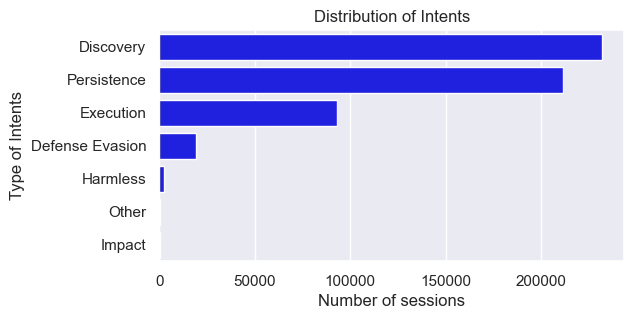

In [18]:
intents = intents_df_exploted.groupby('Set_Fingerprint').size().sort_values(ascending=False).to_frame("Number_of_sessions")
sns.set(style="darkgrid")
plt.figure(figsize=(6,3))
sns.barplot(intents, x="Number_of_sessions", y=intents.index, color="blue", hue_order=intents.index)
plt.title('Distribution of Intents')
plt.xlabel('Number of sessions')
plt.ylabel('Type of Intents')

plt.show()

The presented bar chart shows the most common intentions found in the dataset; Discovery, Persistence and Execution lead the most used type of attacks for each of the sessions.

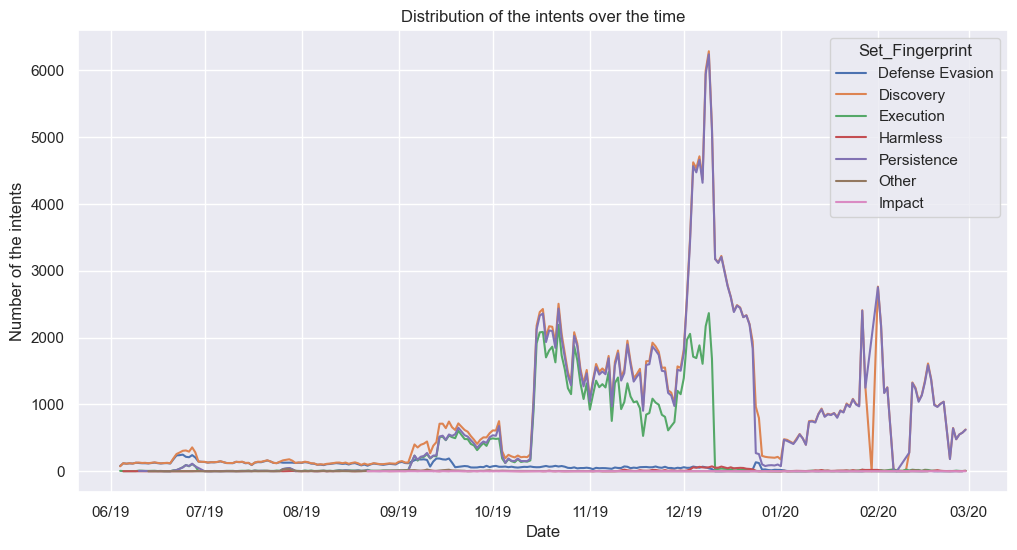

In [19]:
df_intents_distribution = intents_df_exploted.groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().to_frame("Number_of_intents").reset_index()
df_intents_distribution
plt.figure(figsize=(12, 6))
sns.lineplot(
    data = df_intents_distribution,
    x = "first_timestamp",
    y = "Number_of_intents",
    hue="Set_Fingerprint",
    legend=True
)
plt.title("Distribution of the intents over the time")
plt.xlabel("Date")
plt.ylabel("Number of the intents")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

plt.show()

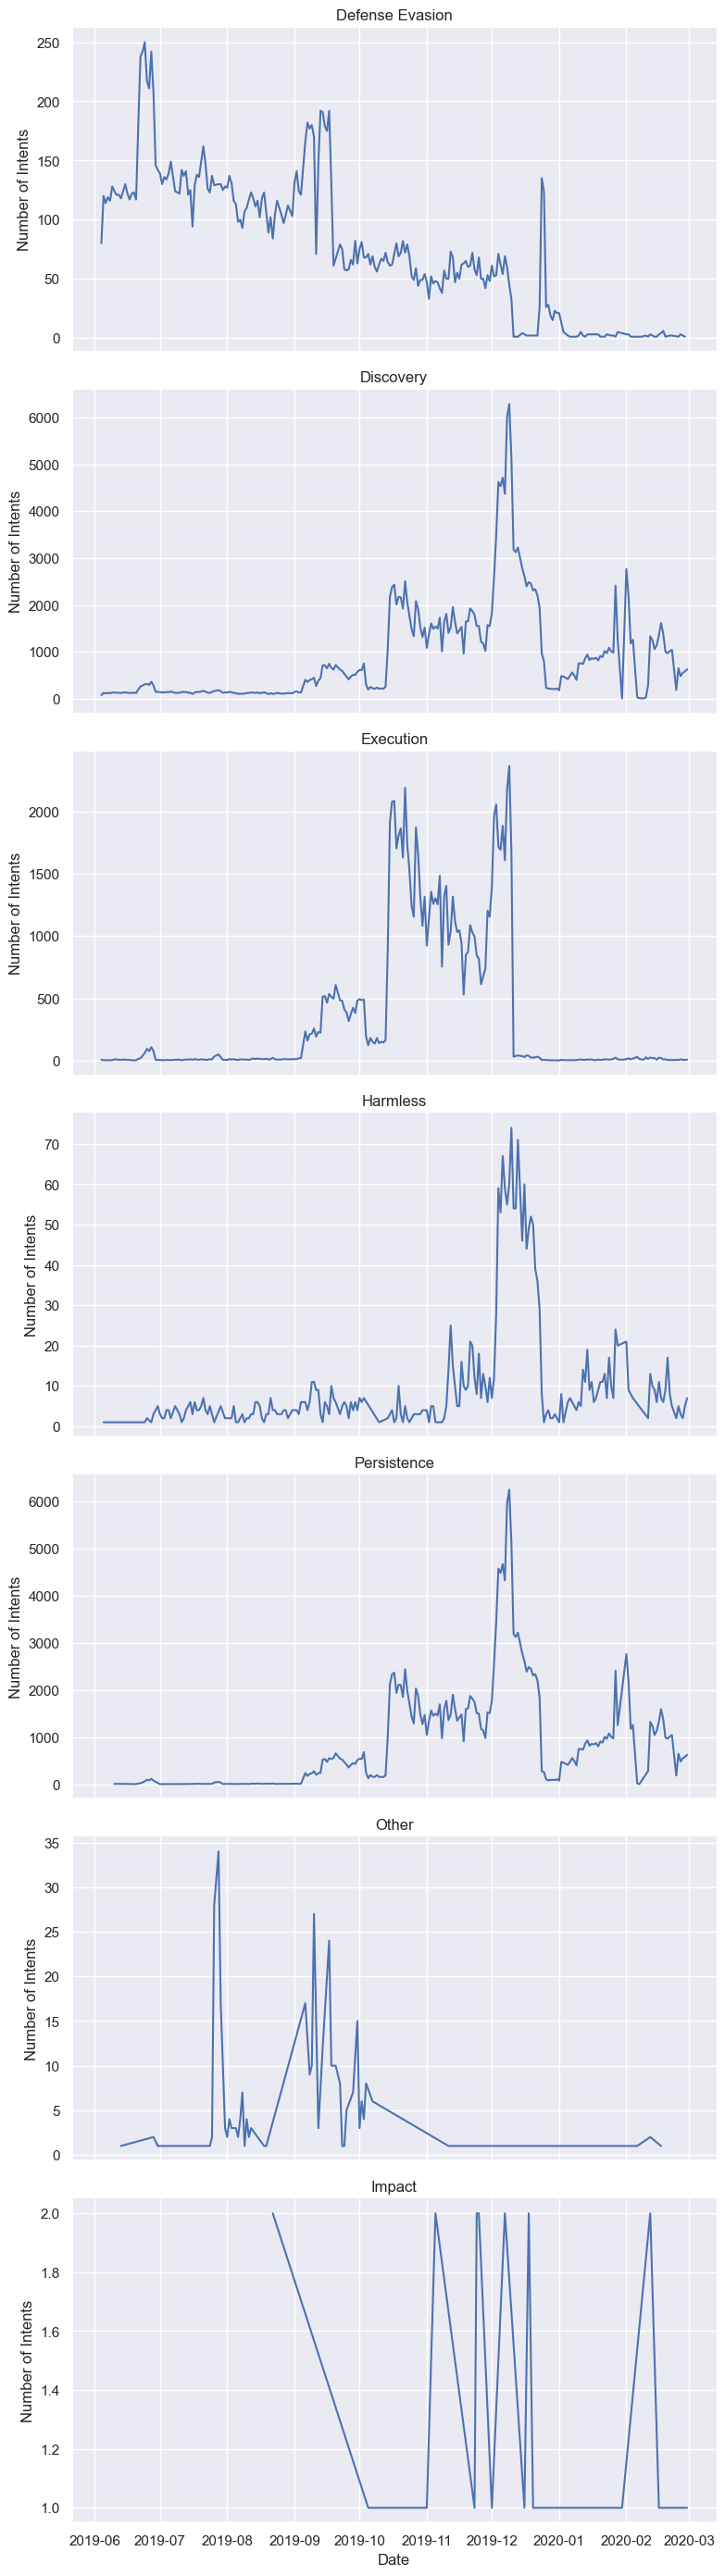

In [20]:
#FIXME WHICH PLOT SHOULD WE USE ?

grid = sns.FacetGrid(df_intents_distribution, col="Set_Fingerprint", col_wrap=1, height=4, sharey=False, aspect=2)

grid.map(sns.lineplot, "first_timestamp", "Number_of_intents")

grid.set_axis_labels("Date", "Number of Intents")
grid.set_titles(col_template="{col_name}")

plt.show()

The distribution of intents unfolds as follows:

**Defense Evasion**:
No significant peaks noticed, with a few attacks observed between July and September 2019, remaining consistently low alongside 'Harmless', 'Impact', and 'Other' intents.

**Execution**:
Displays a sharp peak towards the end of 2019, notably in the last two months.

**Persistence and Discovery**:
Showcase an intriguing trend, reaching their highest peaks towards the end of 2019. These intents exhibit the highest frequency, notably surging towards the year-end, reaching maximum levels.

**1.5. How can text represented numerically? Try to convert the text into numerical representations
(vectors) through Bag of Words (BoW)**

A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

A vocabulary of known words.
A measure of the presence of known words.
It is called a bag-of-words , because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

In [21]:
df_session_cleaned = df.copy()
df_session_cleaned.update(df_session_cleaned["full_session"].apply(lambda x : clean_session(x)))
df_session_cleaned

session_id                                       full_session  \
0                0  [enable, system, shell, sh, cat, proc, mounts,...   
1                1  [enable, system, shell, sh, cat, proc, mounts,...   
2                2  [enable, system, shell, sh, cat, proc, mounts,...   
3                3  [enable, system, shell, sh, cat, proc, mounts,...   
4                4  [enable, system, shell, sh, cat, proc, mounts,...   
...            ...                                                ...   
233030      233042  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233031      233043  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233032      233044  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233033      233045  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233034      233046  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   

                        first_timestamp               Set_Fingerprint  
0      2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]  
1      2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]  
2      2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]  
3      2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]  
4      2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]  
...                                 ...                           ...  
233030 2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]  
233031 2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]  
233032 2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]  
233033 2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]  
233034 2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]  

[233035 rows x 4 columns]

In [22]:
count_vectorizer = CountVectorizer(min_df = 0.05)
bow = count_vectorizer.fit_transform(df_session_cleaned["full_session"].apply(lambda x : " ".join(x)))

In [23]:
df_session_cleaned_bow = pd.DataFrame(bow.toarray(), index=df_session_cleaned.index, columns = list(count_vectorizer.vocabulary_.keys()))
for feature in df_session_cleaned_bow.columns:
    df_session_cleaned_bow[feature] = normalize(df_session_cleaned_bow[feature].values.reshape(-1,1), norm="l2", axis=0)

In [24]:
df_session_cleaned_bow = pd.concat([df_session_cleaned, df_session_cleaned_bow], axis=1)
df_session_cleaned_bow

session_id                                       full_session  \
0                0  [enable, system, shell, sh, cat, proc, mounts,...   
1                1  [enable, system, shell, sh, cat, proc, mounts,...   
2                2  [enable, system, shell, sh, cat, proc, mounts,...   
3                3  [enable, system, shell, sh, cat, proc, mounts,...   
4                4  [enable, system, shell, sh, cat, proc, mounts,...   
...            ...                                                ...   
233030      233042  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233031      233043  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233032      233044  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233033      233045  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233034      233046  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   

                        first_timestamp               Set_Fingerprint  \
0      2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]   
1      2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]   
2      2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]   
3      2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]   
4      2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]   
...                                 ...                           ...   
233030 2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]   
233031 2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]   
233032 2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]   
233033 2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]   
233034 2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]   

          enable   system     shell        sh       cat      proc  ...  \
0       0.000000  0.00000  0.001379  0.007544  0.001109  0.001298  ...   
1       0.000000  0.00000  0.001379  0.007544  0.001109  0.001298  ...   
2       0.000000  0.00000  0.001379  0.007544  0.001109  0.001298  ...   
3       0.000000  0.00000  0.001379  0.007544  0.001109  0.001298  ...   
4       0.000000  0.00000  0.001379  0.007544  0.001109  0.001298  ...   
...          ...      ...       ...       ...       ...       ...  ...   
233030  0.002165  0.00144  0.000000  0.000000  0.000000  0.001730  ...   
233031  0.002165  0.00144  0.000000  0.000000  0.000000  0.001730  ...   
233032  0.002165  0.00144  0.000000  0.000000  0.000000  0.001730  ...   
233033  0.002165  0.00144  0.000000  0.000000  0.000000  0.001730  ...   
233034  0.002165  0.00144  0.000000  0.000000  0.000000  0.001730  ...   

              lh     which   crontab     model       top     lscpu     sleep  \
0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
233030  0.001042  0.002163  0.002159  0.002166  0.002179  0.001443  0.002168   
233031  0.001042  0.002163  0.002159  0.002166  0.002179  0.001443  0.002168   
233032  0.001042  0.002163  0.002159  0.002166  0.002179  0.001443  0.002168   
233033  0.001042  0.002163  0.002159  0.002166  0.002179  0.001443  0.002168   
233034  0.001042  0.002163  0.002159  0.002166  0.002179  0.001443  0.002168   

          passwd   up       txt  
0       0.000559  0.0  0.007507  
1       0.000559  0.0  0.007507  
2       0.000559  0.0  0.007507  
3       0.000559  0.0  0.007507  
4       0.000559  0.0  0.007507  
...          ...  ...       ...  
233030  0.000000  0.0  0.000000  
233031  0.000000  0.0  0.000000  
233032  0.000000  0.0  0.000000  
233033  0.000000  0.0  0.000000  
233034  0.000000  0.0  0.00000

**1.6. Associate each word in each attack session with its TF-IDF value (Term Frequency-Inverse Document Frequency)**

In [25]:
tfidf_vectorizer = TfidfVectorizer(min_df = 0.05)
tfid = tfidf_vectorizer.fit_transform(df_session_cleaned["full_session"].apply(lambda x : " ".join(x)))

In [26]:
df_session_cleaned_tfidf = pd.DataFrame(tfid.toarray(), index=df_session_cleaned.index, columns = list(tfidf_vectorizer.vocabulary_.keys()))
df_session_cleaned_tfidf = pd.concat([df_session_cleaned, df_session_cleaned_tfidf], axis=1)
df_session_cleaned_tfidf

session_id                                       full_session  \
0                0  [enable, system, shell, sh, cat, proc, mounts,...   
1                1  [enable, system, shell, sh, cat, proc, mounts,...   
2                2  [enable, system, shell, sh, cat, proc, mounts,...   
3                3  [enable, system, shell, sh, cat, proc, mounts,...   
4                4  [enable, system, shell, sh, cat, proc, mounts,...   
...            ...                                                ...   
233030      233042  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233031      233043  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233032      233044  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233033      233045  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   
233034      233046  [cat, proc, cpuinfo, grep, name, wc, l, echo, ...   

                        first_timestamp               Set_Fingerprint  \
0      2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]   
1      2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]   
2      2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]   
3      2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]   
4      2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]   
...                                 ...                           ...   
233030 2020-02-29 23:47:28.217237+00:00      [Discovery, Persistence]   
233031 2020-02-29 23:49:01.009046+00:00      [Discovery, Persistence]   
233032 2020-02-29 23:56:18.827281+00:00      [Discovery, Persistence]   
233033 2020-02-29 23:56:56.263104+00:00      [Discovery, Persistence]   
233034 2020-02-29 23:59:22.199490+00:00      [Discovery, Persistence]   

          enable    system     shell       sh       cat      proc  ...  \
0       0.000000  0.000000  0.637244  0.12807  0.510999  0.107935  ...   
1       0.000000  0.000000  0.637244  0.12807  0.510999  0.107935  ...   
2       0.000000  0.000000  0.637244  0.12807  0.510999  0.107935  ...   
3       0.000000  0.000000  0.637244  0.12807  0.510999  0.107935  ...   
4       0.000000  0.000000  0.637244  0.12807  0.510999  0.107935  ...   
...          ...       ...       ...      ...       ...       ...  ...   
233030  0.148482  0.074884  0.000000  0.00000  0.000000  0.274584  ...   
233031  0.148482  0.074884  0.000000  0.00000  0.000000  0.274584  ...   
233032  0.148482  0.074884  0.000000  0.00000  0.000000  0.274584  ...   
233033  0.148482  0.074884  0.000000  0.00000  0.000000  0.274584  ...   
233034  0.148482  0.074884  0.000000  0.00000  0.000000  0.274584  ...   

              lh     which   crontab     model       top     lscpu     sleep  \
0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
233030  0.370178  0.074094  0.075077  0.222748  0.075097  0.296756  0.148408   
233031  0.370178  0.074094  0.075077  0.222748  0.075097  0.296756  0.148408   
233032  0.370178  0.074094  0.075077  0.222748  0.075097  0.296756  0.148408   
233033  0.370178  0.074094  0.075077  0.222748  0.075097  0.296756  0.148408   
233034  0.370178  0.074094  0.075077  0.222748  0.075097  0.296756  0.148408   

          passwd   up       txt  
0       0.126674  0.0  0.128053  
1       0.126674  0.0  0.128053  
2       0.126674  0.0  0.128053  
3       0.126674  0.0  0.128053  
4       0.126674  0.0  0.128053  
...          ...  ...       ...  
233030  0.000000  0.0  0.000000  
233031  0.000000  0.0  0.000000  
233032  0.000000  0.0  0.000000  
233033  0.000000  0.0  0.000000  
233034  0.000000  0.0  0.00000

<br>
<b>Correlation Matrix</b>

In [27]:
df_features_bow = df_session_cleaned_bow.drop(columns=["session_id", "full_session", "first_timestamp", "Set_Fingerprint"])

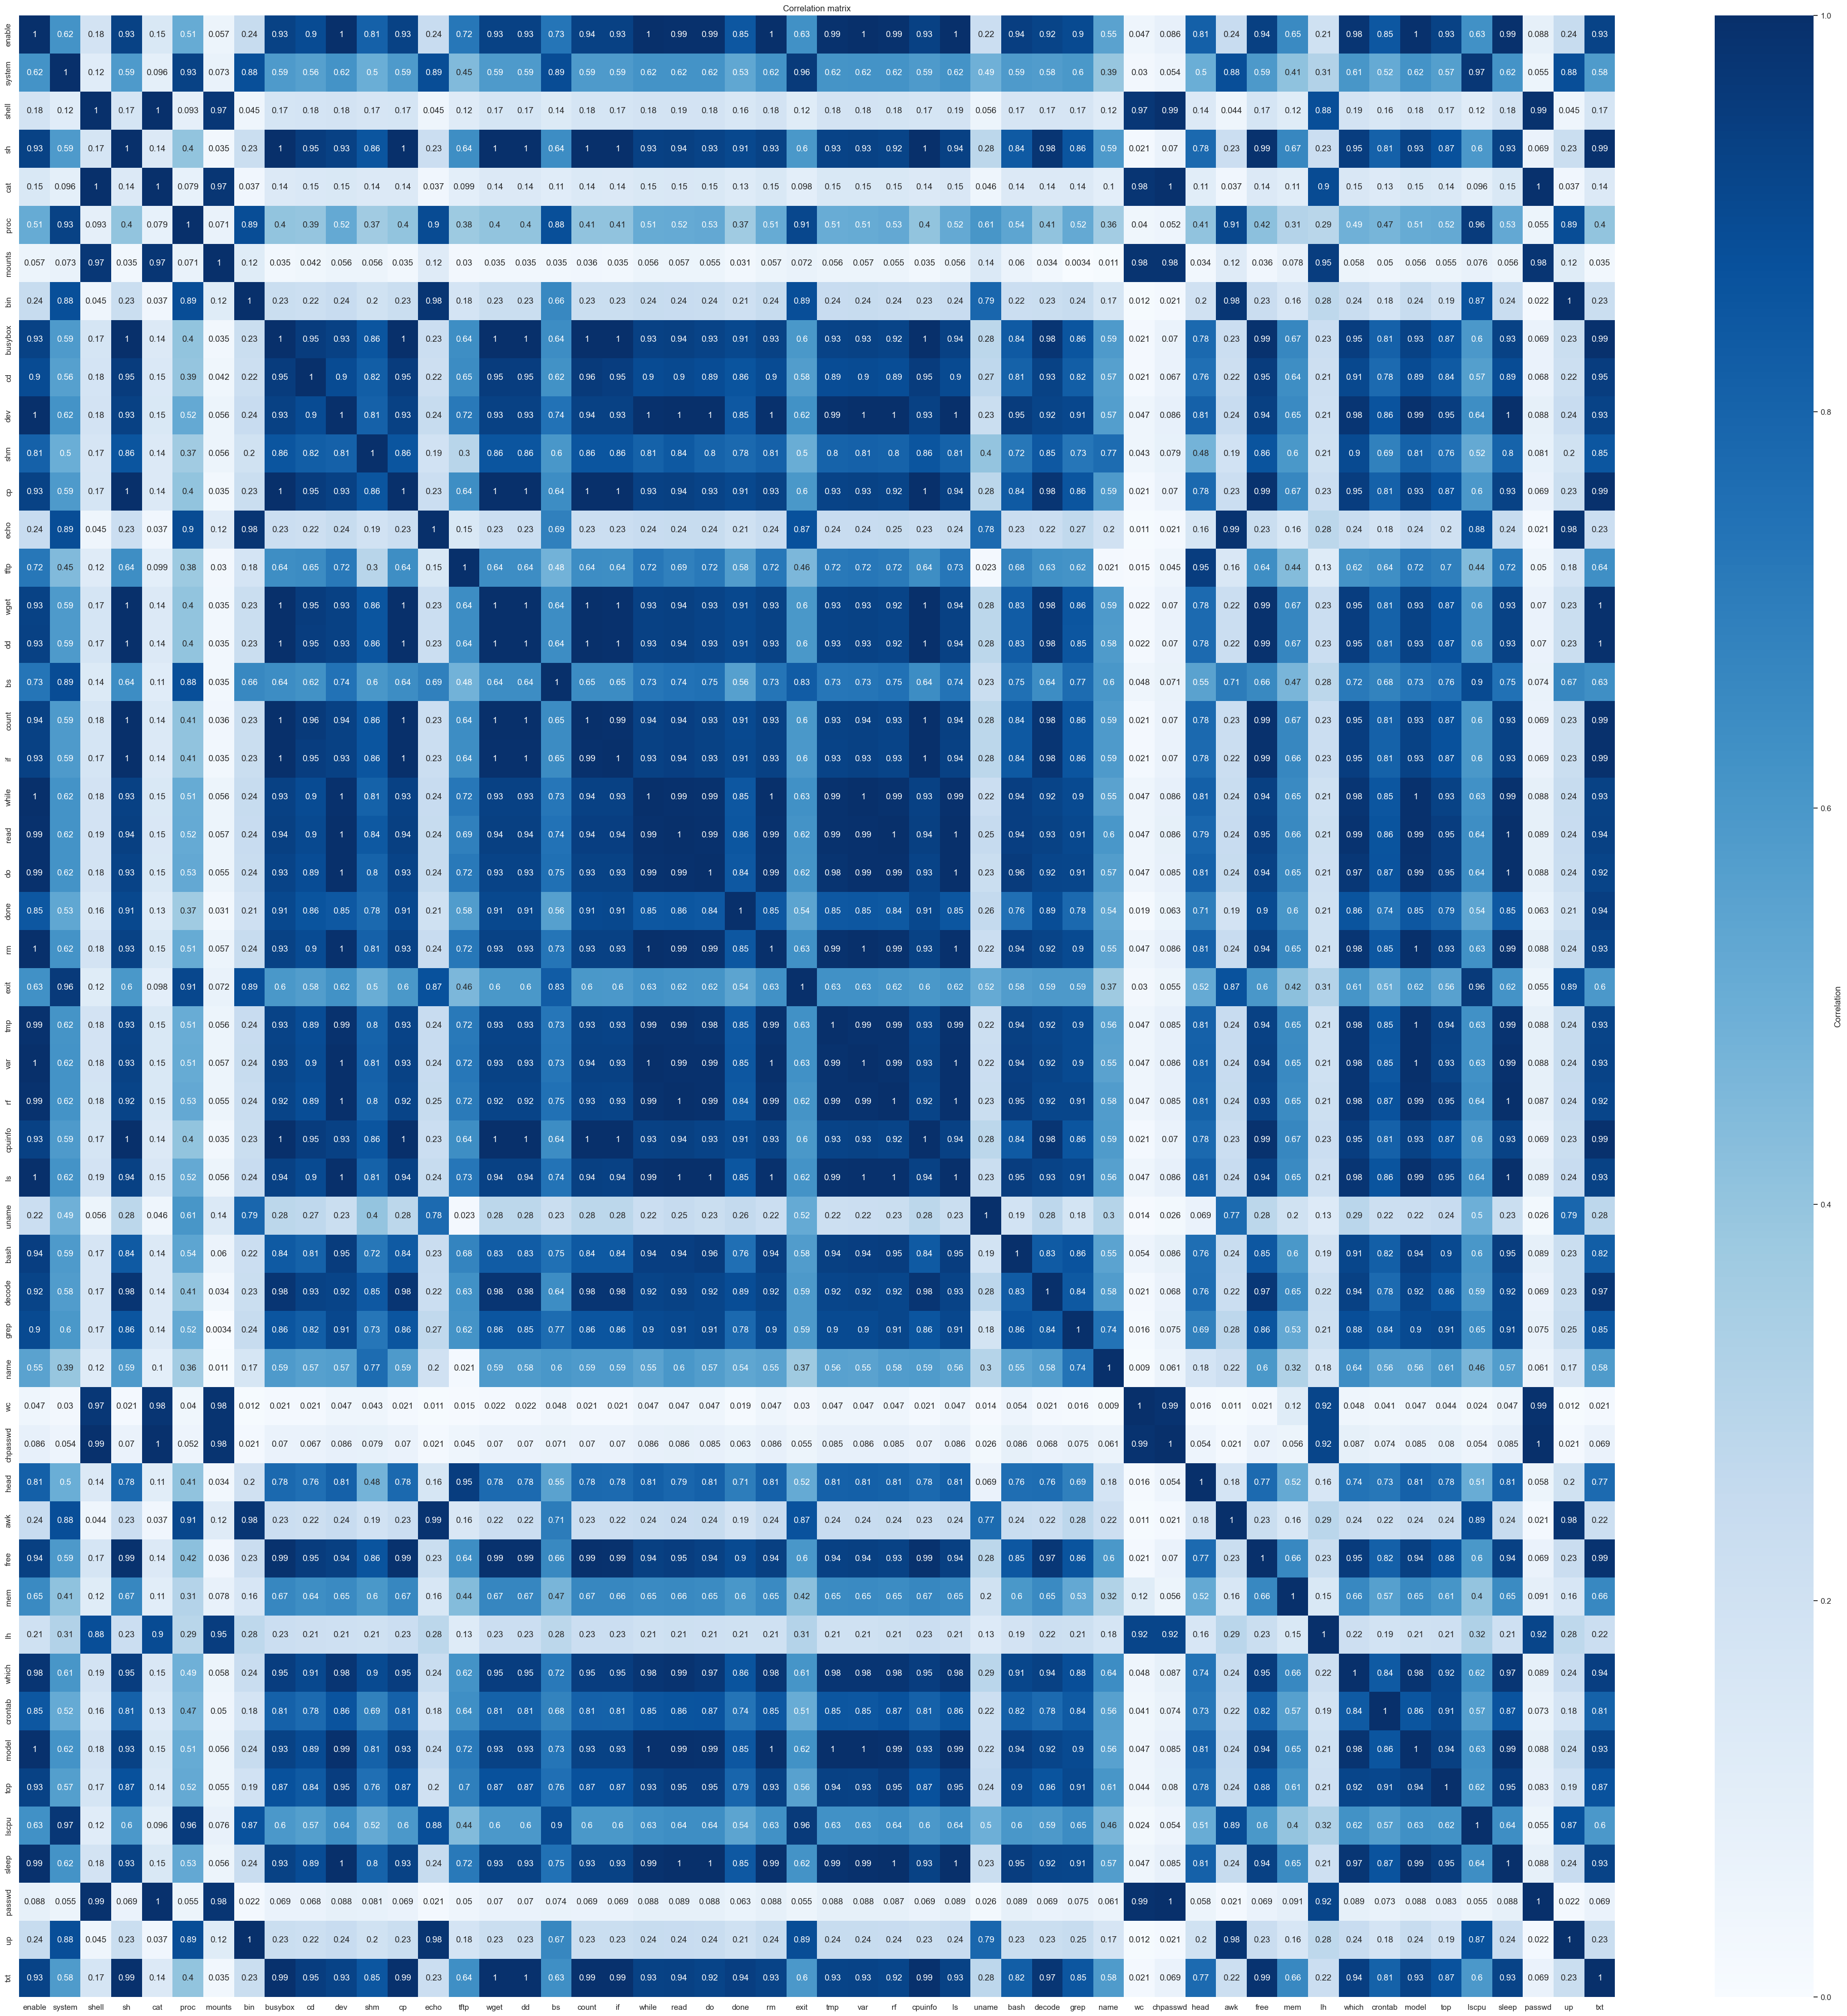

In [28]:
correlation_matrix_bow = df_features_bow.corr().abs()
plt.figure(figsize=(50,50))
sns.heatmap(correlation_matrix_bow, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.title('Correlation matrix')
plt.show()

In [29]:
df_features_tfidf = df_session_cleaned_tfidf.drop(columns=["session_id", "full_session", "first_timestamp", "Set_Fingerprint"])

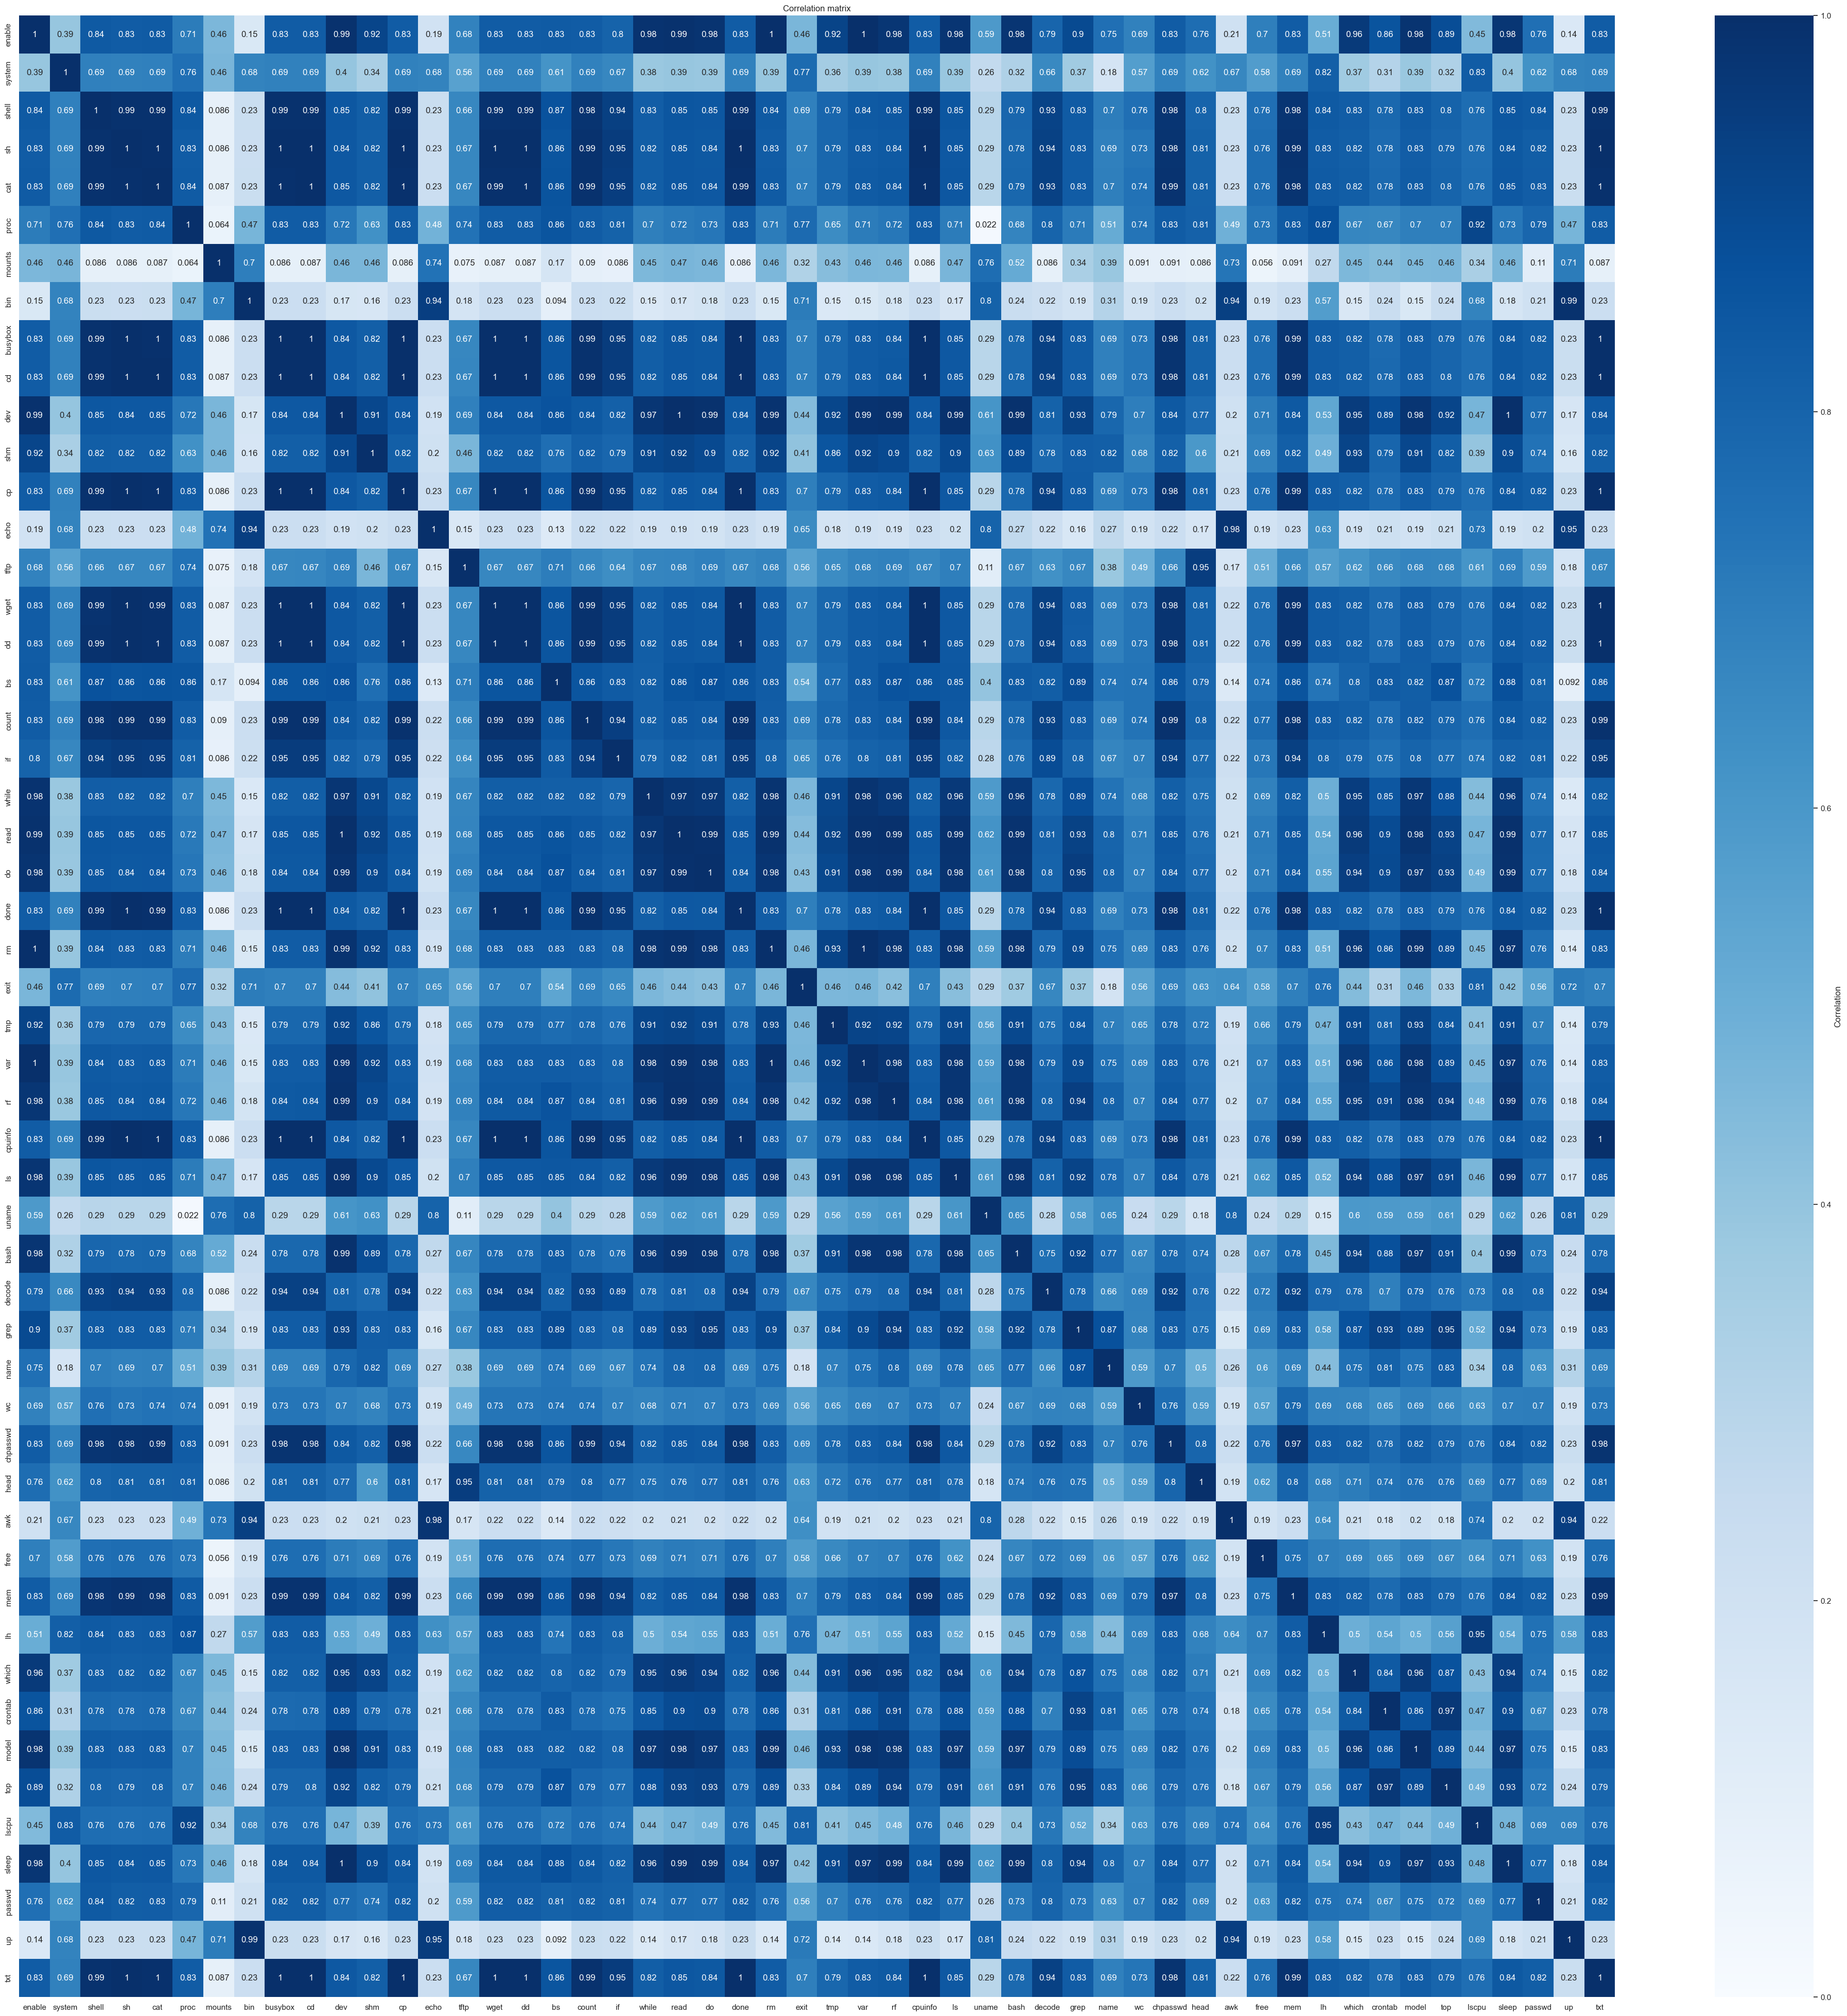

In [30]:
correlation_matrix_tfidf = df_features_tfidf.corr().abs()

plt.figure(figsize=(50,50))
sns.heatmap(correlation_matrix_tfidf, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.title('Correlation matrix')
plt.show()

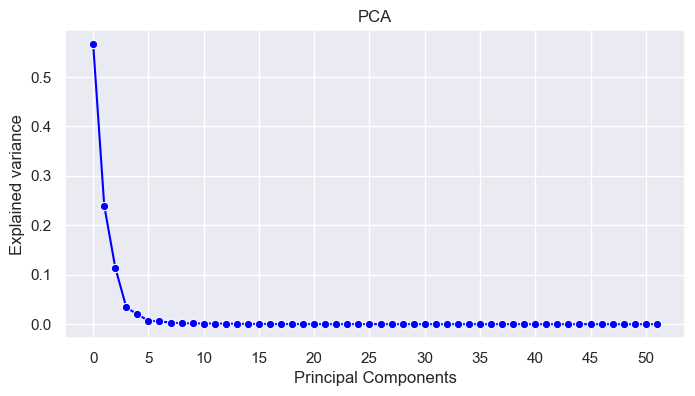

In [31]:
pca_bow = PCA()
pca_bow.fit(df_features_bow)
explained_variance_bow = pca_bow.explained_variance_ratio_

plt.figure(figsize=(8,4))
sns.lineplot(
    data = explained_variance_bow,
    marker = "o",
    color = 'blue'
)
# Set up Seaborn style
sns.set(style="darkgrid")
plt.xticks(range(0, len(explained_variance_bow), 5))
plt.xlabel("Principal Components")
plt.ylabel("Explained variance")
plt.title("PCA")
plt.show()

In [32]:
pca_bow = PCA(n_components=4)
pca_result_bow = pca_bow.fit_transform(df_features_bow)
pca_result_bow = pd.DataFrame(pca_result_bow, columns=[f'PC{i}' for i in range(pca_bow.n_components_)])
pca_result_bow

PC0       PC1       PC2       PC3
0       0.027962 -0.000782 -0.000928 -0.000484
1       0.027962 -0.000782 -0.000928 -0.000484
2       0.027962 -0.000782 -0.000928 -0.000484
3       0.027962 -0.000782 -0.000928 -0.000484
4       0.027962 -0.000782 -0.000928 -0.000484
...          ...       ...       ...       ...
233030 -0.001926 -0.000378  0.003272 -0.000203
233031 -0.001926 -0.000378  0.003272 -0.000203
233032 -0.001926 -0.000378  0.003272 -0.000203
233033 -0.001926 -0.000378  0.003272 -0.000203
233034 -0.001926 -0.000378  0.003272 -0.000203

[233035 rows x 4 columns]

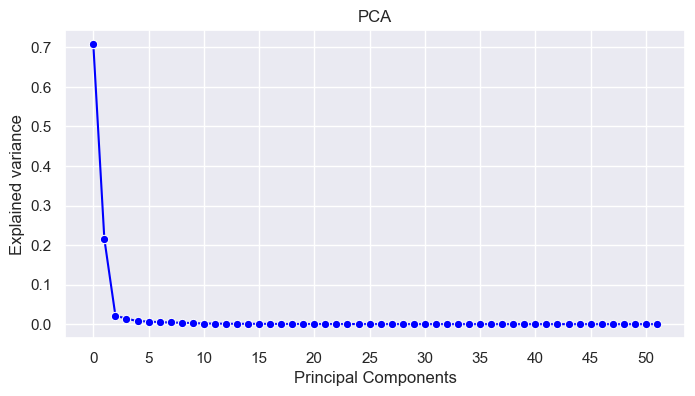

In [33]:
pca_tfidf = PCA()
pca_tfidf.fit(df_features_tfidf)
explained_variance_tfidf = pca_tfidf.explained_variance_ratio_

plt.figure(figsize=(8, 4))
sns.lineplot(
    data = explained_variance_tfidf,
    marker="o",
    color = 'blue'
)
# Set up Seaborn style
sns.set(style="darkgrid")
plt.xticks(range(0, len(explained_variance_tfidf), 5))
plt.xlabel("Principal Components")
plt.ylabel("Explained variance")
plt.title("PCA")
plt.show()

In [34]:
pca_tfidf = PCA(n_components=3)
pca_result_tfidf = pca_tfidf.fit_transform(df_features_tfidf)
pca_result_tfidf = pd.DataFrame(pca_result_tfidf, columns=[f'PC{i}' for i in range(pca_tfidf.n_components_)])
pca_result_tfidf

PC0       PC1       PC2
0       1.241958  0.018738 -0.029312
1       1.241958  0.018738 -0.029312
2       1.241958  0.018738 -0.029312
3       1.241958  0.018738 -0.029312
4       1.241958  0.018738 -0.029312
...          ...       ...       ...
233030 -0.118260  0.177722 -0.000664
233031 -0.118260  0.177722 -0.000664
233032 -0.118260  0.177722 -0.000664
233033 -0.118260  0.177722 -0.000664
233034 -0.118260  0.177722 -0.000664

[233035 rows x 3 columns]